=== KIỂM TRA PERCEPTRON VỚI PHÉP AND ===
Bắt đầu huấn luyện...
Bắt đầu huấn luyện Perceptron với 50 epoch
Số mẫu: 4, Số đặc trưng: 2
Hội tụ tại epoch 8

Kết quả dự đoán cho phép AND:
Đầu vào: [0 0] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG
Đầu vào: [0 1] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG
Đầu vào: [1 0] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG
Đầu vào: [1 1] -> Dự đoán: 1, Thực tế: 1 ✓ ĐÚNG

Tham số cuối cùng:
Trọng số: [0.19675738 0.14075391]
Bias: -0.257

Giải thích:
- Trọng số 1 (0.197): ảnh hưởng của đầu vào thứ nhất
- Trọng số 2 (0.141): ảnh hưởng của đầu vào thứ hai
- Bias (-0.257): ngưỡng quyết định
- Công thức: đầu_ra = step(0.197*x1 + 0.141*x2 + -0.257)

Vẽ biểu đồ quá trình huấn luyện...


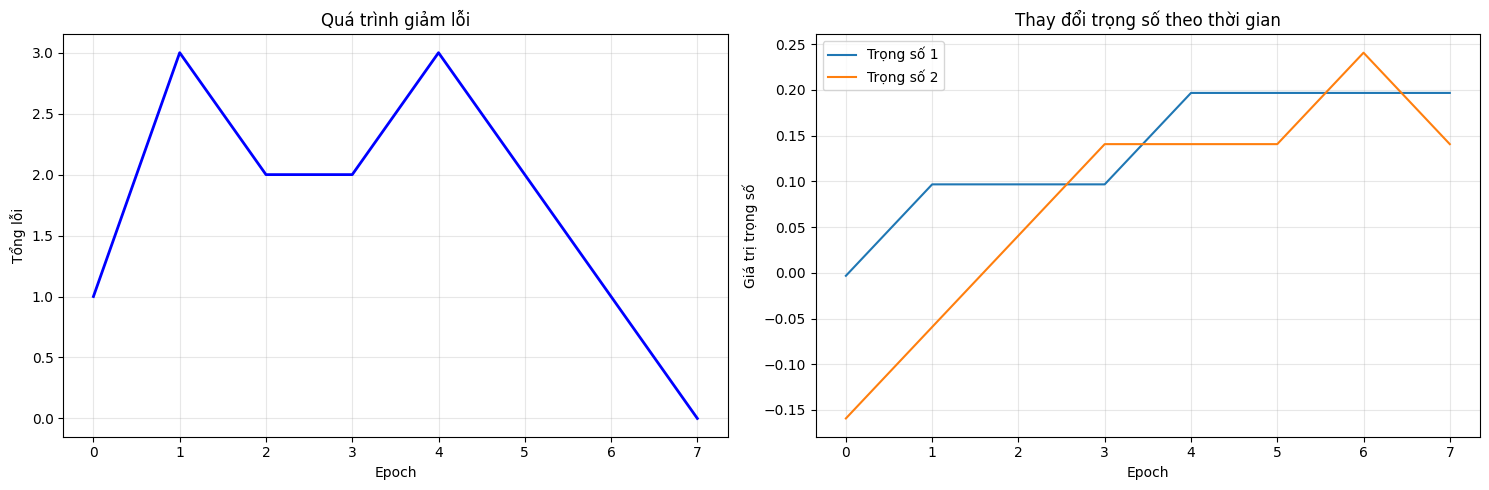

In [4]:
"""
Phần 1: Perceptron - Neuron đơn giản nhất

Perceptron là đơn vị tính toán cơ bản nhất trong neural networks, được lấy cảm hứng từ neuron sinh học. 
Giống như neuron thật nhận tín hiệu từ các neuron khác qua synapse, perceptron nhận đầu vào từ nhiều nguồn, 
xử lý chúng, và tạo ra một tín hiệu đầu ra.

Hãy tưởng tượng perceptron như một người bảo vệ thông minh. Người này nhận thông tin từ nhiều nguồn khác nhau 
(tuổi của khách, cách ăn mặc, thái độ), gán trọng số khác nhau cho từng thông tin (tuổi quan trọng hơn cách ăn mặc), 
tính tổng điểm, và quyết định có cho phép vào hay không dựa trên một ngưỡng nhất định.
"""

# Import các thư viện cần thiết
import numpy as np              # Thư viện tính toán số học
import matplotlib.pyplot as plt # Thư viện vẽ biểu đồ
from typing import Callable, List, Tuple  # Type hints cho code rõ ràng hơn
import warnings
warnings.filterwarnings('ignore')  # Tắt các cảnh báo không cần thiết

class Perceptron:
    """
    Lớp Perceptron đơn giản - đơn vị cơ bản của neural networks
    
    Cấu trúc của Perceptron:
    1. Nhận đầu vào (inputs)
    2. Nhân với trọng số (weights) 
    3. Cộng bias
    4. Áp dụng hàm kích hoạt
    5. Tạo ra đầu ra
    """
    
    def __init__(self, so_dau_vao: int, he_so_hoc: float = 0.01):
        """
        Khởi tạo Perceptron với các tham số ban đầu
        
        Args:
            so_dau_vao: Số lượng đặc trưng đầu vào (ví dụ: 2 cho phép AND có 2 input)
            he_so_hoc: Tốc độ học (learning rate) - quyết định tốc độ cập nhật trọng số
        """
        self.so_dau_vao = so_dau_vao  # Lưu số đầu vào
        self.he_so_hoc = he_so_hoc    # Lưu tốc độ học
        
        # Khởi tạo trọng số ngẫu nhiên nhỏ (gần 0 để tránh bão hòa)
        # Mỗi đầu vào sẽ có một trọng số tương ứng
        self.trong_so = np.random.normal(0, 0.1, so_dau_vao)
        
        # Bias giúp perceptron linh hoạt hơn trong việc phân loại
        # Giống như việc điều chỉnh ngưỡng quyết định
        self.bias = np.random.normal(0, 0.1)
        
        # Lưu trữ lịch sử huấn luyện để theo dõi quá trình học
        self.lich_su_loss = []      # Lịch sử lỗi qua các epoch
        self.lich_su_trong_so = []  # Lịch sử thay đổi trọng số
    
    def ham_kich_hoat(self, x: float) -> float:
        """
        Hàm kích hoạt step function (ngưỡng cứng)
        
        Args:
            x: Giá trị đầu vào (tổng có trọng số)
            
        Returns:
            1 nếu x >= 0, ngược lại trả về 0
            
        Ví dụ: Giống như công tắc đèn - bật (1) hoặc tắt (0)
        """
        return 1 if x >= 0 else 0
    
    def ham_kich_hoat_sigmoid(self, x: float) -> float:
        """
        Hàm sigmoid để có đầu ra liên tục (mượt mà hơn step function)
        
        Args:
            x: Giá trị đầu vào
            
        Returns:
            Giá trị trong khoảng (0, 1)
            
        Sigmoid có dạng: f(x) = 1 / (1 + e^(-x))
        - Khi x rất lớn: f(x) ≈ 1
        - Khi x rất nhỏ: f(x) ≈ 0  
        - Khi x = 0: f(x) = 0.5
        """
        # Giới hạn x để tránh overflow (tràn số)
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def du_doan(self, X: np.ndarray, su_dung_sigmoid: bool = False) -> np.ndarray:
        """
        Dự đoán đầu ra cho một hoặc nhiều mẫu
        
        Quy trình dự đoán:
        1. Tính tích vô hướng: X · W (đầu vào nhân trọng số)
        2. Cộng bias: X · W + b
        3. Áp dụng hàm kích hoạt
        
        Args:
            X: Ma trận đầu vào shape (n_samples, n_features) hoặc (n_features,)
            su_dung_sigmoid: Sử dụng sigmoid thay vì step function
        
        Returns:
            Mảng dự đoán với giá trị 0 hoặc 1 (hoặc xác suất nếu dùng sigmoid)
        """
        # Đảm bảo X có đúng kích thước (ma trận 2D)
        if X.ndim == 1:
            X = X.reshape(1, -1)  # Chuyển từ vector thành ma trận 1 hàng
        
        # Bước 1 & 2: Tính tổng có trọng số (weighted sum)
        # z = x1*w1 + x2*w2 + ... + xn*wn + bias
        z = np.dot(X, self.trong_so) + self.bias
        
        # Bước 3: Áp dụng hàm kích hoạt
        if su_dung_sigmoid:
            # Sử dụng sigmoid cho đầu ra liên tục
            return np.array([self.ham_kich_hoat_sigmoid(zi) for zi in z])
        else:
            # Sử dụng step function cho đầu ra nhị phân
            return np.array([self.ham_kich_hoat(zi) for zi in z])
    
    def huan_luyen(self, X: np.ndarray, y: np.ndarray, so_epoch: int = 100, in_qua_trinh: bool = True):
        """
        Huấn luyện Perceptron với thuật toán học có giám sát (Supervised Learning)
        
        Thuật toán Perceptron Learning:
        1. Khởi tạo trọng số ngẫu nhiên
        2. Với mỗi mẫu huấn luyện:
           - Dự đoán đầu ra
           - Tính lỗi = nhãn thực - dự đoán  
           - Cập nhật trọng số: w = w + α × lỗi × đầu_vào
           - Cập nhật bias: b = b + α × lỗi
        3. Lặp lại cho đến khi hội tụ hoặc đạt số epoch
        
        Args:
            X: Ma trận đặc trưng shape (n_samples, n_features)
            y: Vector nhãn shape (n_samples,) với giá trị 0 hoặc 1
            so_epoch: Số epoch huấn luyện (một epoch = một lần duyệt qua toàn bộ dữ liệu)
            in_qua_trinh: In thông tin quá trình huấn luyện
        """
        if in_qua_trinh:
            print(f"Bắt đầu huấn luyện Perceptron với {so_epoch} epoch")
            print(f"Số mẫu: {len(X)}, Số đặc trưng: {X.shape[1]}")
        
        # Lặp qua từng epoch
        for epoch in range(so_epoch):
            tong_loi = 0  # Đếm tổng số lỗi trong epoch này
            
            # Lưu trọng số hiện tại để theo dõi sự thay đổi
            self.lich_su_trong_so.append(self.trong_so.copy())
            
            # Duyệt qua từng mẫu huấn luyện
            for i in range(len(X)):
                # Bước 1: Dự đoán với trọng số hiện tại
                du_doan = self.du_doan(X[i])
                
                # Bước 2: Tính lỗi
                # lỗi = nhãn_thực - dự_đoán
                # lỗi = 0: dự đoán đúng, không cần cập nhật
                # lỗi = 1: dự đoán 0 nhưng thực tế 1, cần tăng trọng số
                # lỗi = -1: dự đoán 1 nhưng thực tế 0, cần giảm trọng số
                loi = y[i] - du_doan[0]
                
                # Bước 3: Cập nhật trọng số nếu có lỗi
                if loi != 0:
                    # Công thức cập nhật Perceptron:
                    # w_new = w_old + α × lỗi × x
                    # Nếu lỗi > 0: tăng trọng số theo hướng đầu vào
                    # Nếu lỗi < 0: giảm trọng số theo hướng đầu vào
                    self.trong_so += self.he_so_hoc * loi * X[i]
                    
                    # Cập nhật bias tương tự
                    self.bias += self.he_so_hoc * loi
                    
                    # Đếm lỗi để theo dõi
                    tong_loi += abs(loi)
            
            # Lưu lịch sử lỗi
            self.lich_su_loss.append(tong_loi)
            
            # In thông tin tiến trình mỗi 20 epoch
            if in_qua_trinh and (epoch + 1) % 20 == 0:
                do_chinh_xac = self.danh_gia(X, y)
                print(f"Epoch {epoch + 1}/{so_epoch}: Lỗi = {tong_loi}, Độ chính xác = {do_chinh_xac:.3f}")
            
            # Dừng sớm nếu không còn lỗi (đã hội tụ)
            if tong_loi == 0:
                if in_qua_trinh:
                    print(f"Hội tụ tại epoch {epoch + 1}")
                break
    
    def danh_gia(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Đánh giá độ chính xác của mô hình
        
        Args:
            X: Dữ liệu đầu vào
            y: Nhãn thực tế
            
        Returns:
            Độ chính xác (accuracy) từ 0 đến 1
        """
        du_doan = self.du_doan(X)  # Dự đoán cho toàn bộ dữ liệu
        # Tính tỷ lệ dự đoán đúng
        return np.mean(du_doan == y)
    
    def ve_bieu_do_huan_luyen(self):
        """
        Vẽ biểu đồ trực quan hóa quá trình huấn luyện
        
        Gồm 2 biểu đồ:
        1. Biểu đồ lỗi theo epoch (để xem mô hình có hội tụ không)
        2. Biểu đồ thay đổi trọng số (để hiểu cách mô hình học)
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Biểu đồ 1: Lỗi giảm theo thời gian
        axes[0].plot(self.lich_su_loss, 'b-', linewidth=2)
        axes[0].set_title('Quá trình giảm lỗi')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Tổng lỗi')
        axes[0].grid(True, alpha=0.3)
        
        # Biểu đồ 2: Thay đổi trọng số theo thời gian
        if len(self.lich_su_trong_so) > 0:
            trong_so_array = np.array(self.lich_su_trong_so)
            # Vẽ đường cho mỗi trọng số
            for i in range(self.so_dau_vao):
                axes[1].plot(trong_so_array[:, i], label=f'Trọng số {i+1}')
            
            axes[1].set_title('Thay đổi trọng số theo thời gian')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Giá trị trọng số')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ===== DEMO: KIỂM TRA PERCEPTRON VỚI PHÉP AND =====
print("=== KIỂM TRA PERCEPTRON VỚI PHÉP AND ===")

# Tạo dữ liệu cho phép AND logic
# Phép AND chỉ trả về 1 khi cả hai đầu vào đều là 1
X_and = np.array([[0, 0],    # 0 AND 0 = 0
                  [0, 1],    # 0 AND 1 = 0  
                  [1, 0],    # 1 AND 0 = 0
                  [1, 1]])   # 1 AND 1 = 1

y_and = np.array([0, 0, 0, 1])  # Kết quả tương ứng

# Tạo và cấu hình Perceptron
# so_dau_vao=2: vì phép AND có 2 đầu vào
# he_so_hoc=0.1: tốc độ học vừa phải (không quá nhanh, không quá chậm)
perceptron_and = Perceptron(so_dau_vao=2, he_so_hoc=0.1)

# Huấn luyện mô hình
print("Bắt đầu huấn luyện...")
perceptron_and.huan_luyen(X_and, y_and, so_epoch=50)

# Kiểm tra kết quả sau huấn luyện
print(f"\nKết quả dự đoán cho phép AND:")
for i, (x, y_thuc) in enumerate(zip(X_and, y_and)):
    y_du_doan = perceptron_and.du_doan(x)[0]
    ket_qua = "✓ ĐÚNG" if y_du_doan == y_thuc else "✗ SAI"
    print(f"Đầu vào: {x} -> Dự đoán: {y_du_doan}, Thực tế: {y_thuc} {ket_qua}")

# Hiển thị tham số đã học được
print(f"\nTham số cuối cùng:")
print(f"Trọng số: {perceptron_and.trong_so}")
print(f"Bias: {perceptron_and.bias:.3f}")

# Giải thích ý nghĩa trọng số:
print(f"\nGiải thích:")
print(f"- Trọng số 1 ({perceptron_and.trong_so[0]:.3f}): ảnh hưởng của đầu vào thứ nhất")  
print(f"- Trọng số 2 ({perceptron_and.trong_so[1]:.3f}): ảnh hưởng của đầu vào thứ hai")
print(f"- Bias ({perceptron_and.bias:.3f}): ngưỡng quyết định")
print(f"- Công thức: đầu_ra = step({perceptron_and.trong_so[0]:.3f}*x1 + {perceptron_and.trong_so[1]:.3f}*x2 + {perceptron_and.bias:.3f})")

# Vẽ biểu đồ quá trình huấn luyện
print(f"\nVẽ biểu đồ quá trình huấn luyện...")
perceptron_and.ve_bieu_do_huan_luyen()

=== KIỂM TRA PERCEPTRON VỚI PHÉP AND ===
Bắt đầu huấn luyện...
Bắt đầu huấn luyện Perceptron với 50 epoch
Số mẫu: 4, Số đặc trưng: 2
Hội tụ tại epoch 7

Kết quả dự đoán cho phép AND:
Đầu vào: [0 0] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG
Đầu vào: [0 1] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG
Đầu vào: [1 0] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG
Đầu vào: [1 1] -> Dự đoán: 1, Thực tế: 1 ✓ ĐÚNG

Tham số cuối cùng:
Trọng số: [0.2097605  0.15903685]
Bias: -0.283

Giải thích:
- Trọng số 1 (0.210): ảnh hưởng của đầu vào thứ nhất
- Trọng số 2 (0.159): ảnh hưởng của đầu vào thứ hai
- Bias (-0.283): ngưỡng quyết định
- Công thức: đầu_ra = step(0.210*x1 + 0.159*x2 + -0.283)

Vẽ biểu đồ quá trình huấn luyện...


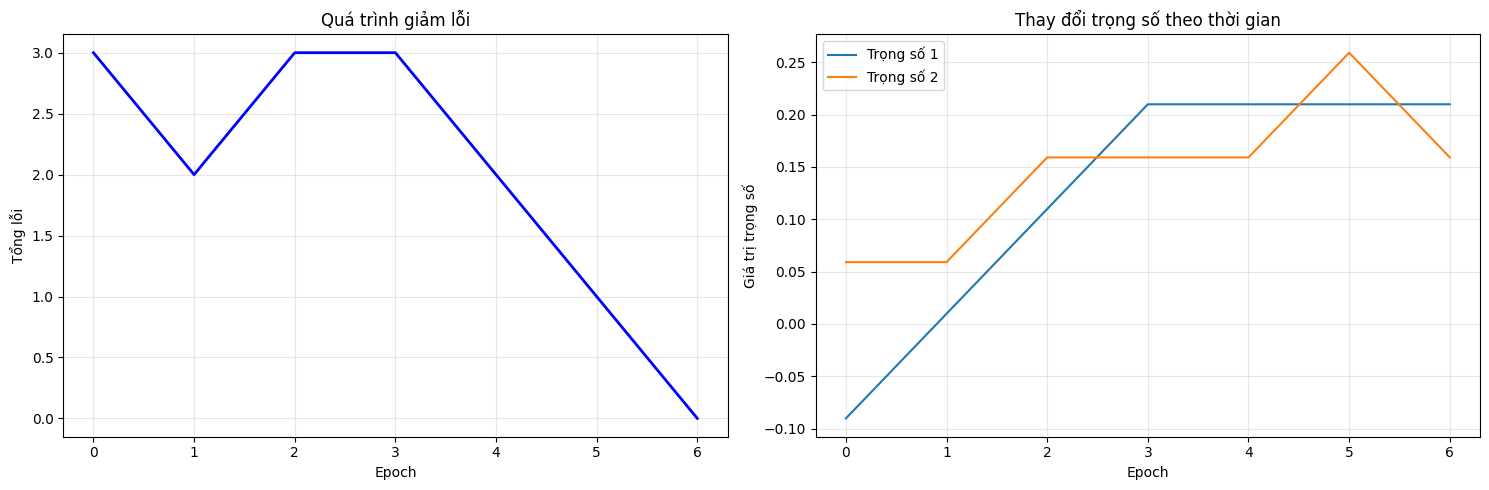


HẠN CHẾ CỦA PERCEPTRON: BÀI TOÁN XOR
Dữ liệu XOR:
Đầu vào [0,0] -> 0 (cả hai đều 0)
Đầu vào [0,1] -> 1 (khác nhau)
Đầu vào [1,0] -> 1 (khác nhau)
Đầu vào [1,1] -> 0 (cả hai đều 1)

Thử huấn luyện Perceptron học XOR...
(Dự đoán: sẽ THẤT BẠI vì XOR không phải bài toán tuyến tính)
Bắt đầu huấn luyện Perceptron với 100 epoch
Số mẫu: 4, Số đặc trưng: 2
Epoch 20/100: Lỗi = 4, Độ chính xác = 0.500
Epoch 40/100: Lỗi = 4, Độ chính xác = 0.500
Epoch 60/100: Lỗi = 4, Độ chính xác = 0.500
Epoch 80/100: Lỗi = 4, Độ chính xác = 0.500
Epoch 100/100: Lỗi = 4, Độ chính xác = 0.500

Kết quả dự đoán cho phép XOR:
Đầu vào: [0 0] -> Dự đoán: 1, Thực tế: 0 ✗ SAI
Đầu vào: [0 1] -> Dự đoán: 1, Thực tế: 1 ✓ ĐÚNG
Đầu vào: [1 0] -> Dự đoán: 0, Thực tế: 1 ✗ SAI
Đầu vào: [1 1] -> Dự đoán: 0, Thực tế: 0 ✓ ĐÚNG

Độ chính xác XOR: 0.500 (2/4 mẫu đúng)

TẠI SAO PERCEPTRON THẤT BẠI VỚI XOR?
1. Perceptron chỉ tạo ra được đường phân loại TUYẾN TÍNH
2. XOR cần đường phân loại KHÔNG TUYẾN TÍNH (cong hoặc nhiều đoạn)
3. Kh

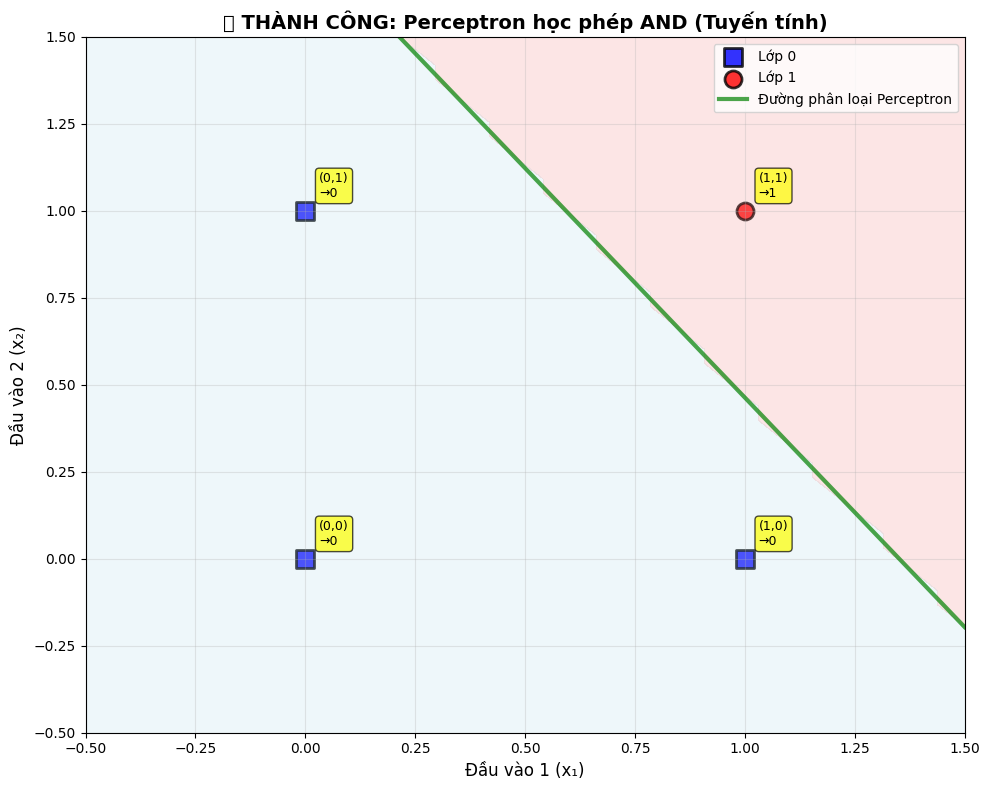

2. Perceptron thất bại với phép XOR


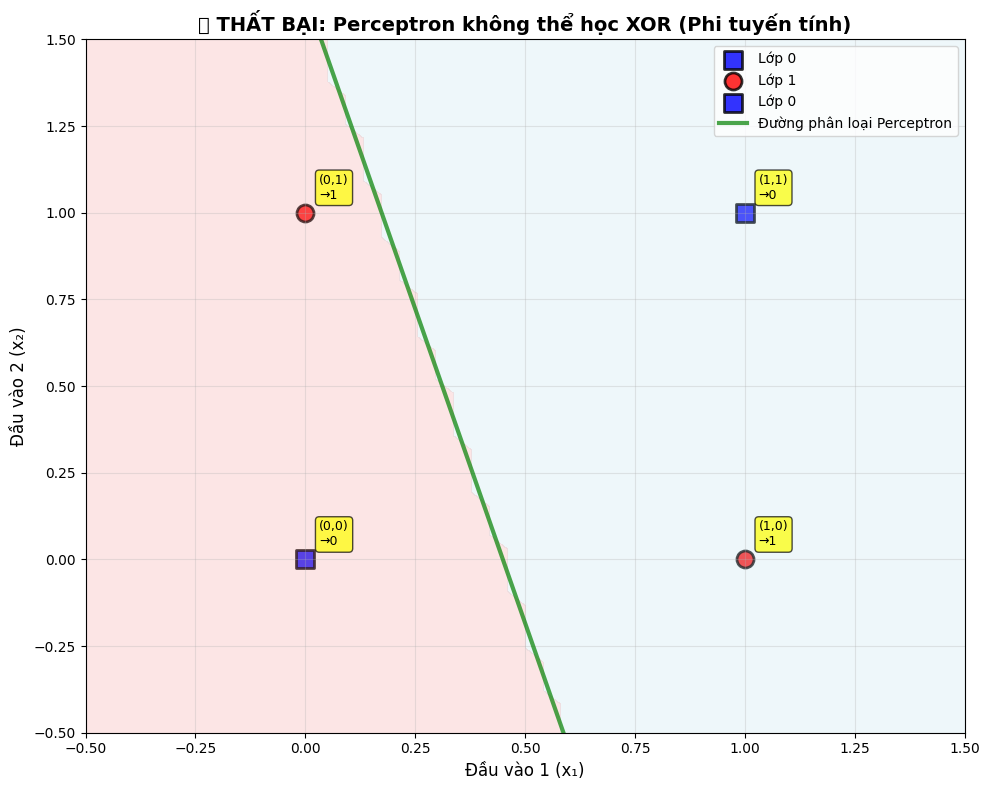


PHÂN TÍCH CHI TIẾT:

🔹 Phép AND (Linearly Separable - Tách biệt được bằng đường thẳng):
   Điểm (0,0)→0 và (0,1)→0 và (1,0)→0 ở một phía
   Điểm (1,1)→1 ở phía kia
   ➜ CÓ THỂ vẽ một đường thẳng tách biệt hai nhóm

🔹 Phép XOR (Not Linearly Separable - KHÔNG tách biệt được bằng đường thẳng):
   Điểm (0,0)→0 và (1,1)→0 ở các góc đối diện
   Điểm (0,1)→1 và (1,0)→1 ở các góc đối diện khác
   ➜ KHÔNG THỂ vẽ một đường thẳng nào tách biệt được

🔧 Giải pháp cho bài toán XOR:
1. Multi-Layer Perceptron (MLP) - Nhiều lớp Perceptron
2. Neural Networks với hidden layers
3. Các mô hình phi tuyến tính khác

📊 Kết quả so sánh:
   AND: Độ chính xác = 100.0%
   XOR: Độ chính xác = 50.0%

Biểu đồ quá trình huấn luyện XOR (không hội tụ):


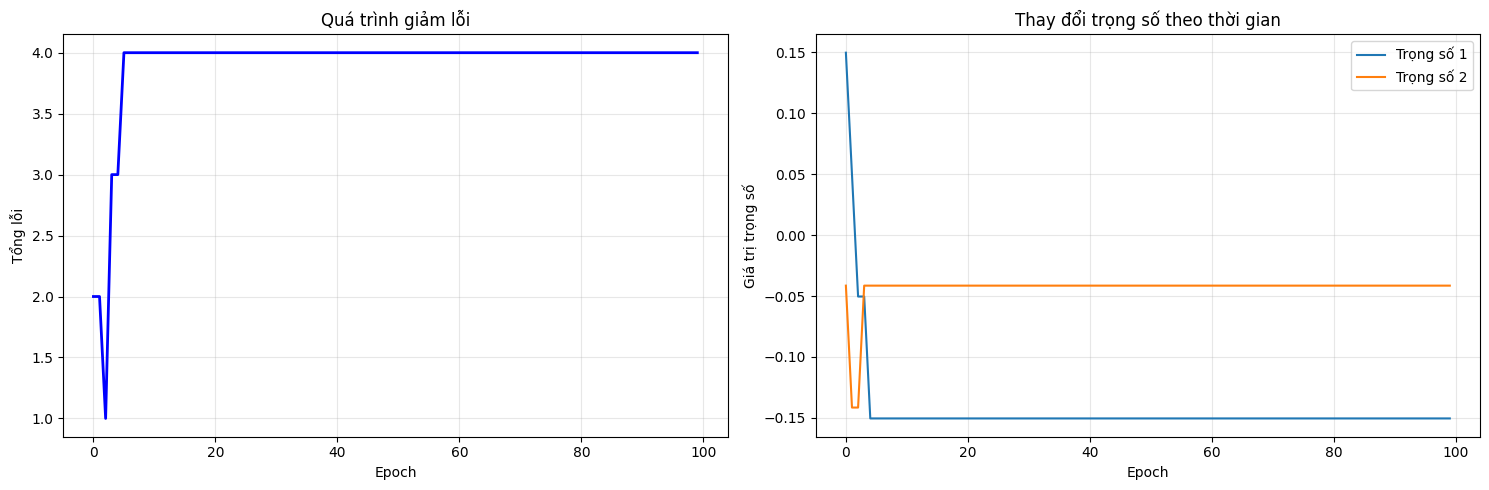

In [ ]:
"""
HẠN CHẾ QUAN TRỌNG CỦA PERCEPTRON:
Perceptron chỉ có thể giải quyết những bài toán PHÂN LOẠI TUYẾN TÍNH.

Điều này có nghĩa là:
- Các lớp dữ liệu phải có thể tách biệt bằng một ĐƯỜNG THẲNG (trong 2D) 
- Hoặc một SIÊU PHẲNG (hyperplane) trong không gian nhiều chiều

Bài toán XOR là ví dụ điển hình về bài toán KHÔNG TUYẾN TÍNH:
- Không thể vẽ một đường thẳng nào để tách biệt được các điểm XOR
- Do đó Perceptron sẽ THẤT BẠI hoàn toàn với XOR
"""

print("\n" + "="*50)
print("HẠN CHẾ CỦA PERCEPTRON: BÀI TOÁN XOR")
print("="*50)

# Tạo dữ liệu cho phép XOR (Exclusive OR)
# XOR chỉ trả về 1 khi hai đầu vào KHÁC NHAU
X_xor = np.array([[0, 0],    # 0 XOR 0 = 0 (giống nhau)
                  [0, 1],    # 0 XOR 1 = 1 (khác nhau)
                  [1, 0],    # 1 XOR 0 = 1 (khác nhau)  
                  [1, 1]])   # 1 XOR 1 = 0 (giống nhau)

y_xor = np.array([0, 1, 1, 0])  # Kết quả XOR tương ứng

print("Dữ liệu XOR:")
print("Đầu vào [0,0] -> 0 (cả hai đều 0)")
print("Đầu vào [0,1] -> 1 (khác nhau)")  
print("Đầu vào [1,0] -> 1 (khác nhau)")
print("Đầu vào [1,1] -> 0 (cả hai đều 1)")

# Tạo Perceptron để thử học XOR
perceptron_xor = Perceptron(so_dau_vao=2, he_so_hoc=0.1)

print("\nThử huấn luyện Perceptron học XOR...")
print("(Dự đoán: sẽ THẤT BẠI vì XOR không phải bài toán tuyến tính)")

# Huấn luyện với nhiều epoch hơn để chắc chắn
perceptron_xor.huan_luyen(X_xor, y_xor, so_epoch=100)

# Kiểm tra kết quả (sẽ thất bại)
print(f"\nKết quả dự đoán cho phép XOR:")
tong_dung = 0
for i, (x, y_thuc) in enumerate(zip(X_xor, y_xor)):
    y_du_doan = perceptron_xor.du_doan(x)[0]
    ket_qua = "✓ ĐÚNG" if y_du_doan == y_thuc else "✗ SAI"
    if y_du_doan == y_thuc:
        tong_dung += 1
    print(f"Đầu vào: {x} -> Dự đoán: {y_du_doan}, Thực tế: {y_thuc} {ket_qua}")

# Tính độ chính xác
do_chinh_xac = perceptron_xor.danh_gia(X_xor, y_xor)
print(f"\nĐộ chính xác XOR: {do_chinh_xac:.3f} ({tong_dung}/4 mẫu đúng)")

# Giải thích tại sao thất bại
print(f"\n" + "="*60)
print("TẠI SAO PERCEPTRON THẤT BẠI VỚI XOR?")
print("="*60)
print("1. Perceptron chỉ tạo ra được đường phân loại TUYẾN TÍNH")
print("2. XOR cần đường phân loại KHÔNG TUYẾN TÍNH (cong hoặc nhiều đoạn)")
print("3. Không thể vẽ MỘT ĐƯỜNG THẲNG nào tách biệt được các điểm XOR")
print("4. Do đó Perceptron không bao giờ hội tụ được với XOR")

def ve_duong_phan_loai_2d(perceptron, X, y, tieu_de="Đường phân loại"):
    """
    Vẽ đường phân loại cho bài toán 2D để trực quan hóa
    
    Mục đích:
    - Giúp hiểu tại sao Perceptron thành công với AND nhưng thất bại với XOR
    - Thấy rõ sự khác biệt giữa bài toán tuyến tính và phi tuyến tính
    
    Args:
        perceptron: Mô hình Perceptron đã huấn luyện
        X: Dữ liệu đầu vào (2D)
        y: Nhãn lớp (0 hoặc 1)
        tieu_de: Tiêu đề biểu đồ
    """
    plt.figure(figsize=(10, 8))
    
    # Bước 1: Vẽ các điểm dữ liệu với màu sắc và hình dạng khác nhau
    for i in range(len(X)):
        # Lớp 0: màu xanh, hình vuông
        # Lớp 1: màu đỏ, hình tròn
        mau = 'red' if y[i] == 1 else 'blue'
        ky_hieu = 'o' if y[i] == 1 else 's'  # 'o' = tròn, 's' = vuông
        nhan = f'Lớp {y[i]}' if i == 0 or (i > 0 and y[i] != y[i-1]) else ""
        
        plt.scatter(X[i, 0], X[i, 1], c=mau, marker=ky_hieu, s=150, 
                   alpha=0.8, edgecolors='black', linewidth=2, label=nhan)
    
    # Bước 2: Vẽ đường phân loại (nếu có thể)
    # Đường phân loại có phương trình: w1*x1 + w2*x2 + bias = 0
    if abs(perceptron.trong_so[1]) > 1e-10:  # Tránh chia cho số rất nhỏ
        x_min, x_max = -0.5, 1.5
        
        # Giải phương trình để tìm x2 theo x1:
        # w1*x1 + w2*x2 + bias = 0
        # => x2 = -(w1*x1 + bias) / w2
        x1_values = np.linspace(x_min, x_max, 100)
        x2_values = -(perceptron.trong_so[0] * x1_values + perceptron.bias) / perceptron.trong_so[1]
        
        plt.plot(x1_values, x2_values, 'g-', linewidth=3, alpha=0.7, 
                label='Đường phân loại Perceptron')
        
        # Tô màu vùng phân loại để thấy rõ hơn
        x1_mesh, x2_mesh = np.meshgrid(np.linspace(-0.5, 1.5, 50), 
                                       np.linspace(-0.5, 1.5, 50))
        
        # Dự đoán cho toàn bộ không gian
        mesh_points = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
        Z = perceptron.du_doan(mesh_points)
        Z = Z.reshape(x1_mesh.shape)
        
        # Tô màu nền cho hai vùng
        plt.contourf(x1_mesh, x2_mesh, Z, levels=1, alpha=0.2, colors=['lightblue', 'lightcoral'])
    
    # Bước 3: Tùy chỉnh biểu đồ
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.xlabel('Đầu vào 1 (x₁)', fontsize=12)
    plt.ylabel('Đầu vào 2 (x₂)', fontsize=12)
    plt.title(tieu_de, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Thêm annotation cho các điểm
    for i, (x, y_val) in enumerate(zip(X, y)):
        plt.annotate(f'({x[0]},{x[1]})\n→{y_val}', 
                    (x[0], x[1]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Vẽ so sánh giữa AND (thành công) và XOR (thất bại)
print(f"\nVẽ biểu đồ so sánh:")
print("1. Perceptron học thành công phép AND")
ve_duong_phan_loai_2d(perceptron_and, X_and, y_and, 
                     "✅ THÀNH CÔNG: Perceptron học phép AND (Tuyến tính)")

print("2. Perceptron thất bại với phép XOR")  
ve_duong_phan_loai_2d(perceptron_xor, X_xor, y_xor, 
                     "❌ THẤT BẠI: Perceptron không thể học XOR (Phi tuyến tính)")

# Giải thích chi tiết hơn
print(f"\n" + "="*70)
print("PHÂN TÍCH CHI TIẾT:")
print("="*70)

print("\n🔹 Phép AND (Linearly Separable - Tách biệt được bằng đường thẳng):")
print("   Điểm (0,0)→0 và (0,1)→0 và (1,0)→0 ở một phía")
print("   Điểm (1,1)→1 ở phía kia")  
print("   ➜ CÓ THỂ vẽ một đường thẳng tách biệt hai nhóm")

print("\n🔹 Phép XOR (Not Linearly Separable - KHÔNG tách biệt được bằng đường thẳng):")
print("   Điểm (0,0)→0 và (1,1)→0 ở các góc đối diện")
print("   Điểm (0,1)→1 và (1,0)→1 ở các góc đối diện khác")
print("   ➜ KHÔNG THỂ vẽ một đường thẳng nào tách biệt được")

print(f"\n🔧 Giải pháp cho bài toán XOR:")
print("1. Multi-Layer Perceptron (MLP) - Nhiều lớp Perceptron")
print("2. Neural Networks với hidden layers")
print("3. Các mô hình phi tuyến tính khác")

print(f"\n📊 Kết quả so sánh:")
print(f"   AND: Độ chính xác = {perceptron_and.danh_gia(X_and, y_and):.1%}")
print(f"   XOR: Độ chính xác = {perceptron_xor.danh_gia(X_xor, y_xor):.1%}")

# Vẽ biểu đồ quá trình huấn luyện XOR để thấy nó không hội tụ
print(f"\nBiểu đồ quá trình huấn luyện XOR (không hội tụ):")
perceptron_xor.ve_bieu_do_huan_luyen()

=== CÁC HÀM KÍCH HOẠT ===


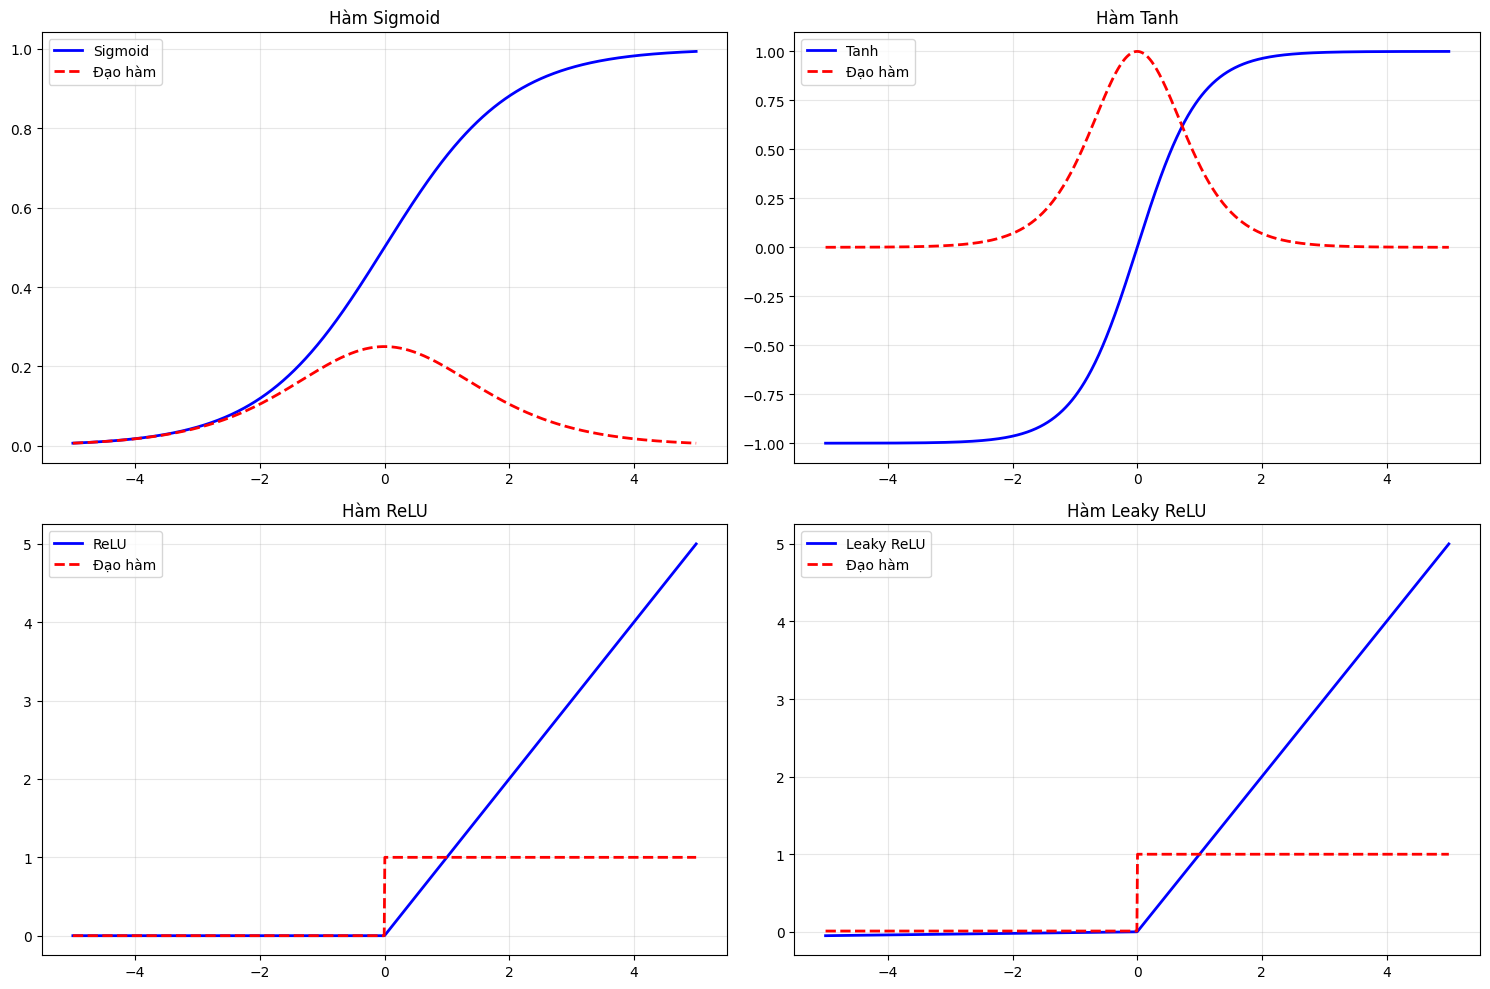

In [7]:
"""Phần 2: Multi-layer Perceptron - Sức mạnh của nhiều lớp
Kiến trúc MLP
Multi-layer Perceptron (MLP) là sự mở rộng của Perceptron đơn với nhiều lớp neuron. Nếu Perceptron đơn như một người ra quyết định đơn giản, thì MLP như một ủy ban với nhiều chuyên gia, mỗi người đưa ra ý kiến của mình, và quyết định cuối cùng được hình thành qua sự tương tác phức tạp giữa tất cả các ý kiến.
"""
class HamKichHoat:
    """
    Lớp chứa các hàm kích hoạt và đạo hàm của chúng
    """
    
    @staticmethod
    def sigmoid(x):
        """Hàm sigmoid"""
        x = np.clip(x, -500, 500)  # Tránh overflow
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_dao_ham(x):
        """Đạo hàm của sigmoid"""
        s = HamKichHoat.sigmoid(x)
        return s * (1 - s)
    
    @staticmethod
    def tanh(x):
        """Hàm tanh"""
        return np.tanh(x)
    
    @staticmethod
    def tanh_dao_ham(x):
        """Đạo hàm của tanh"""
        return 1 - np.tanh(x) ** 2
    
    @staticmethod
    def relu(x):
        """Hàm ReLU"""
        return np.maximum(0, x)
    
    @staticmethod
    def relu_dao_ham(x):
        """Đạo hàm của ReLU"""
        return (x > 0).astype(float)
    
    @staticmethod
    def leaky_relu(x, alpha=0.01):
        """Hàm Leaky ReLU"""
        return np.where(x > 0, x, alpha * x)
    
    @staticmethod
    def leaky_relu_dao_ham(x, alpha=0.01):
        """Đạo hàm của Leaky ReLU"""
        return np.where(x > 0, 1, alpha)

# Trực quan hóa các hàm kích hoạt
def ve_ham_kich_hoat():
    """
    Vẽ biểu đồ các hàm kích hoạt
    """
    x = np.linspace(-5, 5, 1000)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Sigmoid
    y_sigmoid = HamKichHoat.sigmoid(x)
    dy_sigmoid = HamKichHoat.sigmoid_dao_ham(x)
    axes[0, 0].plot(x, y_sigmoid, 'b-', linewidth=2, label='Sigmoid')
    axes[0, 0].plot(x, dy_sigmoid, 'r--', linewidth=2, label='Đạo hàm')
    axes[0, 0].set_title('Hàm Sigmoid')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Tanh
    y_tanh = HamKichHoat.tanh(x)
    dy_tanh = HamKichHoat.tanh_dao_ham(x)
    axes[0, 1].plot(x, y_tanh, 'b-', linewidth=2, label='Tanh')
    axes[0, 1].plot(x, dy_tanh, 'r--', linewidth=2, label='Đạo hàm')
    axes[0, 1].set_title('Hàm Tanh')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ReLU
    y_relu = HamKichHoat.relu(x)
    dy_relu = HamKichHoat.relu_dao_ham(x)
    axes[1, 0].plot(x, y_relu, 'b-', linewidth=2, label='ReLU')
    axes[1, 0].plot(x, dy_relu, 'r--', linewidth=2, label='Đạo hàm')
    axes[1, 0].set_title('Hàm ReLU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Leaky ReLU
    y_leaky = HamKichHoat.leaky_relu(x)
    dy_leaky = HamKichHoat.leaky_relu_dao_ham(x)
    axes[1, 1].plot(x, y_leaky, 'b-', linewidth=2, label='Leaky ReLU')
    axes[1, 1].plot(x, dy_leaky, 'r--', linewidth=2, label='Đạo hàm')
    axes[1, 1].set_title('Hàm Leaky ReLU')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("=== CÁC HÀM KÍCH HOẠT ===")
ve_ham_kich_hoat()

In [ ]:
"""Xây dựng MLP hoàn chỉnh"""
class MangNeuronNhanTao:
    """
    Lớp mạng neuron đa lớp hoàn chỉnh với thuật toán lan truyền ngược
    """
    
    def __init__(self, kich_thuoc_cac_lop: List[int], ham_kich_hoat: str = 'sigmoid', he_so_hoc: float = 0.01):
        """
        Khởi tạo mạng neuron
        
        Args:
            kich_thuoc_cac_lop: Danh sách số neuron trong từng lớp [đầu_vào, ẩn1, ẩn2, ..., đầu_ra]
            ham_kich_hoat: Tên hàm kích hoạt ('sigmoid', 'tanh', 'relu', 'leaky_relu')
            he_so_hoc: Tốc độ học
        """
        self.kich_thuoc_cac_lop = kich_thuoc_cac_lop
        self.so_lop = len(kich_thuoc_cac_lop)
        self.he_so_hoc = he_so_hoc
        
        # Thiết lập hàm kích hoạt
        self.thiet_lap_ham_kich_hoat(ham_kich_hoat)
        
        # Khởi tạo trọng số và bias
        self.khoi_tao_tham_so()
        
        # Lưu trữ lịch sử huấn luyện
        self.lich_su_loss = []
        self.lich_su_accuracy = []
    
    def thiet_lap_ham_kich_hoat(self, ten_ham: str):
        """Thiết lập hàm kích hoạt và đạo hàm"""
        if ten_ham == 'sigmoid':
            self.ham_kich_hoat = HamKichHoat.sigmoid
            self.dao_ham_kich_hoat = HamKichHoat.sigmoid_dao_ham
        elif ten_ham == 'tanh':
            self.ham_kich_hoat = HamKichHoat.tanh
            self.dao_ham_kich_hoat = HamKichHoat.tanh_dao_ham
        elif ten_ham == 'relu':
            self.ham_kich_hoat = HamKichHoat.relu
            self.dao_ham_kich_hoat = HamKichHoat.relu_dao_ham
        elif ten_ham == 'leaky_relu':
            self.ham_kich_hoat = HamKichHoat.leaky_relu
            self.dao_ham_kich_hoat = HamKichHoat.leaky_relu_dao_ham
        else:
            raise ValueError(f"Hàm kích hoạt '{ten_ham}' không được hỗ trợ")
    
    def khoi_tao_tham_so(self):
        """Khởi tạo trọng số và bias theo phương pháp Xavier"""
        self.trong_so = []
        self.bias = []
        
        for i in range(self.so_lop - 1):
            # Phương pháp Xavier initialization
            fan_in = self.kich_thuoc_cac_lop[i]
            fan_out = self.kich_thuoc_cac_lop[i + 1]
            limit = np.sqrt(6 / (fan_in + fan_out))
            
            W = np.random.uniform(-limit, limit, (self.kich_thuoc_cac_lop[i], self.kich_thuoc_cac_lop[i + 1]))
            b = np.zeros((1, self.kich_thuoc_cac_lop[i + 1]))
            
            self.trong_so.append(W)
            self.bias.append(b)
    
    def lan_truyen_thuan(self, X: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Thực hiện lan truyền thuận
        
        Args:
            X: Dữ liệu đầu vào shape (n_samples, n_features)
        
        Returns:
            activations: Danh sách giá trị kích hoạt tại mỗi lớp
            z_values: Danh sách giá trị trước khi kích hoạt
        """
        activations = [X]  # Lớp đầu vào
        z_values = []
        
        for i in range(self.so_lop - 1):
            # Tính tổng có trọng số
            z = np.dot(activations[i], self.trong_so[i]) + self.bias[i]
            z_values.append(z)
            
            # Áp dụng hàm kích hoạt
            if i == self.so_lop - 2:  # Lớp cuối cùng
                # Sử dụng sigmoid cho đầu ra nhị phân
                a = HamKichHoat.sigmoid(z)
            else:
                a = self.ham_kich_hoat(z)
            
            activations.append(a)
        
        return activations, z_values
    
    def lan_truyen_nguoc(self, X: np.ndarray, y: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Thực hiện thuật toán lan truyền ngược
        
        Args:
            X: Dữ liệu đầu vào
            y: Nhãn thực tế
        
        Returns:
            grad_w: Gradient của trọng số
            grad_b: Gradient của bias
        """
        m = X.shape[0]  # Số mẫu
        
        # Lan truyền thuận
        activations, z_values = self.lan_truyen_thuan(X)
        
        # Khởi tạo gradient
        grad_w = [np.zeros_like(w) for w in self.trong_so]
        grad_b = [np.zeros_like(b) for b in self.bias]
        
        # Tính lỗi ở lớp cuối
        delta = activations[-1] - y.reshape(-1, 1)
        
        # Lan truyền ngược
        for i in range(self.so_lop - 2, -1, -1):
            # Tính gradient cho trọng số và bias
            grad_w[i] = np.dot(activations[i].T, delta) / m
            grad_b[i] = np.mean(delta, axis=0, keepdims=True)
            
            # Tính delta cho lớp trước đó (nếu không phải lớp đầu tiên)
            if i > 0:
                # Gradient từ lớp tiếp theo
                delta_prev = np.dot(delta, self.trong_so[i].T)
                
                # Nhân với đạo hàm hàm kích hoạt
                delta = delta_prev * self.dao_ham_kich_hoat(z_values[i-1])
        
        return grad_w, grad_b
    
    def cap_nhat_tham_so(self, grad_w: List[np.ndarray], grad_b: List[np.ndarray]):
        """Cập nhật trọng số và bias"""
        for i in range(len(self.trong_so)):
            self.trong_so[i] -= self.he_so_hoc * grad_w[i]
            self.bias[i] -= self.he_so_hoc * grad_b[i]
    
    def tinh_loss(self, y_thuc: np.ndarray, y_du_doan: np.ndarray) -> float:
        """Tính Binary Cross Entropy Loss"""
        # Tránh log(0)
        y_du_doan = np.clip(y_du_doan, 1e-15, 1 - 1e-15)
        return -np.mean(y_thuc * np.log(y_du_doan) + (1 - y_thuc) * np.log(1 - y_du_doan))
    
    def du_doan(self, X: np.ndarray) -> np.ndarray:
        """Dự đoán cho dữ liệu mới"""
        activations, _ = self.lan_truyen_thuan(X)
        return activations[-1].flatten()
    
    def du_doan_lop(self, X: np.ndarray, nguong: float = 0.5) -> np.ndarray:
        """Dự đoán lớp (0 hoặc 1)"""
        y_prob = self.du_doan(X)
        return (y_prob >= nguong).astype(int)
    
    def huan_luyen(self, X: np.ndarray, y: np.ndarray, so_epoch: int = 1000, 
                  X_val: np.ndarray = None, y_val: np.ndarray = None, in_qua_trinh: bool = True):
        """
        Huấn luyện mạng neuron
        
        Args:
            X: Dữ liệu huấn luyện
            y: Nhãn huấn luyện
            so_epoch: Số epoch
            X_val: Dữ liệu validation (tùy chọn)
            y_val: Nhãn validation (tùy chọn)
            in_qua_trinh: In thông tin quá trình
        """
        if in_qua_trinh:
            print(f"Bắt đầu huấn luyện mạng neuron với {so_epoch} epoch")
            print(f"Kiến trúc mạng: {' -> '.join(map(str, self.kich_thuoc_cac_lop))}")
        
        for epoch in range(so_epoch):
            # Lan truyền ngược và cập nhật
            grad_w, grad_b = self.lan_truyen_nguoc(X, y)
            self.cap_nhat_tham_so(grad_w, grad_b)
            
            # Tính loss và accuracy
            if epoch % 100 == 0:
                y_pred = self.du_doan(X)
                loss = self.tinh_loss(y, y_pred)
                accuracy = np.mean((y_pred >= 0.5) == y)
                
                self.lich_su_loss.append(loss)
                self.lich_su_accuracy.append(accuracy)
                
                if in_qua_trinh:
                    thong_tin = f"Epoch {epoch:4d}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}"
                    
                    # Thêm thông tin validation nếu có
                    if X_val is not None and y_val is not None:
                        y_val_pred = self.du_doan(X_val)
                        val_loss = self.tinh_loss(y_val, y_val_pred)
                        val_accuracy = np.mean((y_val_pred >= 0.5) == y_val)
                        thong_tin += f", Val_Loss = {val_loss:.4f}, Val_Acc = {val_accuracy:.4f}"
                    
                    print(thong_tin)
    
    def ve_bieu_do_huan_luyen(self):
        """Vẽ biểu đồ quá trình huấn luyện"""
        if not self.lich_su_loss:
            print("Chưa có dữ liệu huấn luyện để vẽ biểu đồ")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        epochs = range(0, len(self.lich_su_loss) * 100, 100)
        
        # Biểu đồ Loss
        axes[0].plot(epochs, self.lich_su_loss, 'b-', linewidth=2)
        axes[0].set_title('Quá trình giảm Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)
        
        # Biểu đồ Accuracy
        axes[1].plot(epochs, self.lich_su_accuracy, 'g-', linewidth=2)
        axes[1].set_title('Quá trình tăng Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def in_thong_tin_mang(self):
        """In thông tin chi tiết về mạng"""
        print(f"=== THÔNG TIN MẠNG NEURON ===")
        print(f"Kiến trúc: {' -> '.join(map(str, self.kich_thuoc_cac_lop))}")
        print(f"Số lớp: {self.so_lop}")
        print(f"Tổng số tham số: {sum(w.size for w in self.trong_so) + sum(b.size for b in self.bias)}")
        
        for i, (w, b) in enumerate(zip(self.trong_so, self.bias)):
            print(f"Lớp {i+1}: Trọng số {w.shape}, Bias {b.shape}")

            

=== GIẢI QUYẾT BÀI TOÁN XOR VỚI MLP ===
=== THÔNG TIN MẠNG NEURON ===
Kiến trúc: 2 -> 4 -> 1
Số lớp: 3
Tổng số tham số: 17
Lớp 1: Trọng số (2, 4), Bias (1, 4)
Lớp 2: Trọng số (4, 1), Bias (1, 1)
Bắt đầu huấn luyện mạng neuron với 2000 epoch
Kiến trúc mạng: 2 -> 4 -> 1
Epoch    0: Loss = 0.6941, Accuracy = 0.5000
Epoch  100: Loss = 0.6811, Accuracy = 0.5000
Epoch  200: Loss = 0.5740, Accuracy = 0.7500
Epoch  300: Loss = 0.4278, Accuracy = 0.7500
Epoch  400: Loss = 0.2285, Accuracy = 1.0000
Epoch  500: Loss = 0.1041, Accuracy = 1.0000
Epoch  600: Loss = 0.0559, Accuracy = 1.0000
Epoch  700: Loss = 0.0354, Accuracy = 1.0000
Epoch  800: Loss = 0.0249, Accuracy = 1.0000
Epoch  900: Loss = 0.0189, Accuracy = 1.0000
Epoch 1000: Loss = 0.0150, Accuracy = 1.0000
Epoch 1100: Loss = 0.0123, Accuracy = 1.0000
Epoch 1200: Loss = 0.0104, Accuracy = 1.0000
Epoch 1300: Loss = 0.0090, Accuracy = 1.0000
Epoch 1400: Loss = 0.0079, Accuracy = 1.0000
Epoch 1500: Loss = 0.0070, Accuracy = 1.0000
Epoch 1600:

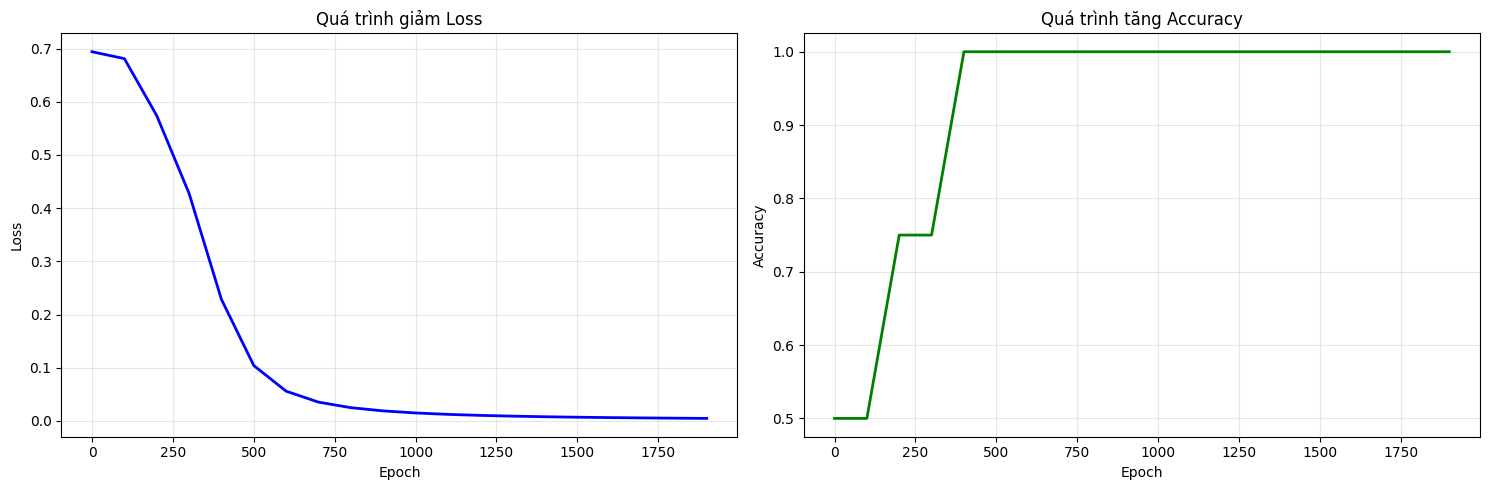

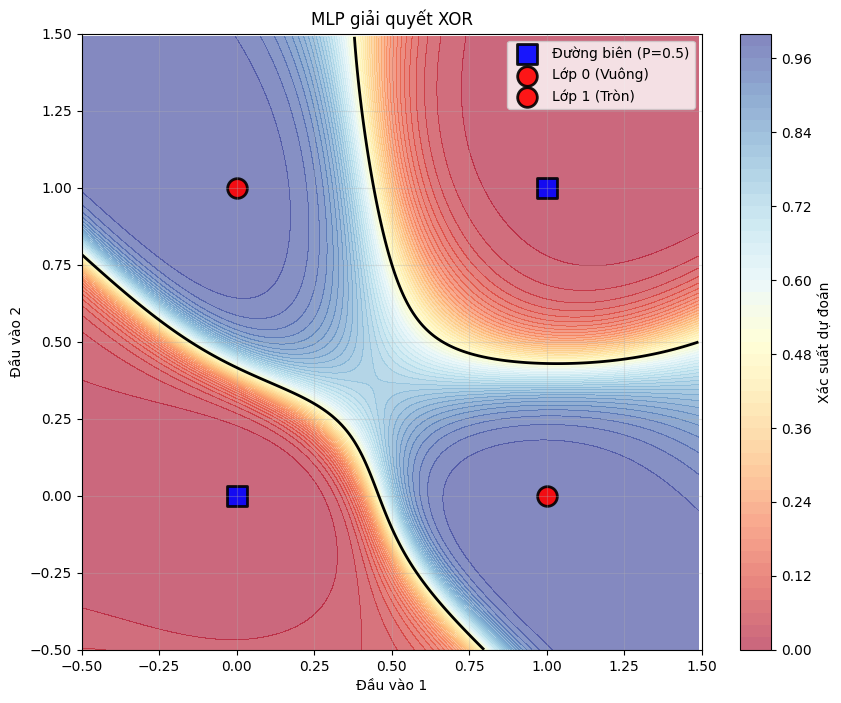

In [12]:
"""Bây giờ chúng ta sẽ sử dụng MLP để giải quyết bài toán XOR mà Perceptron đơn không thể xử lý được:"""

def bai_toan_xor_voi_mlp():
    """
    Giải quyết bài toán XOR bằng MLP
    """
    print("=== GIẢI QUYẾT BÀI TOÁN XOR VỚI MLP ===")
    
    # Dữ liệu XOR
    X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y_xor = np.array([0, 1, 1, 0])
    
    # Tạo mạng với 1 lớp ẩn
    mlp = MangNeuronNhanTao(
        kich_thuoc_cac_lop=[2, 4, 1],  # 2 đầu vào, 4 neuron ẩn, 1 đầu ra
        ham_kich_hoat='sigmoid',
        he_so_hoc=1.0
    )
    
    mlp.in_thong_tin_mang()
    
    # Huấn luyện
    mlp.huan_luyen(X_xor, y_xor, so_epoch=2000)
    
    # Kiểm tra kết quả
    print(f"\n=== KẾT QUẢ GIẢI XOR ===")
    for i, (x, y_thuc) in enumerate(zip(X_xor, y_xor)):
        y_prob = mlp.du_doan(x.reshape(1, -1))[0]
        y_du_doan = int(y_prob >= 0.5)
        print(f"Đầu vào: {x} -> Xác suất: {y_prob:.4f}, Dự đoán: {y_du_doan}, Thực tế: {y_thuc}")
    
    # Tính độ chính xác
    y_pred_all = mlp.du_doan_lop(X_xor)
    accuracy = np.mean(y_pred_all == y_xor)
    print(f"\nĐộ chính xác: {accuracy:.4f}")
    
    # Vẽ biểu đồ huấn luyện
    mlp.ve_bieu_do_huan_luyen()
    
    return mlp

# Chạy bài toán XOR
mlp_xor = bai_toan_xor_voi_mlp()

"""Trực quan hóa quyết định của MLP"""

def ve_vung_quyet_dinh_mlp(mlp, X, y, do_phan_giai=0.01, tieu_de="Vùng quyết định MLP"):
    """
    Vẽ vùng quyết định của MLP cho bài toán 2D
    """
    plt.figure(figsize=(10, 8))
    
    # Tạo lưới điểm
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, do_phan_giai),
                         np.arange(y_min, y_max, do_phan_giai))
    
    # Dự đoán cho từng điểm trên lưới
    luoi_diem = np.c_[xx.ravel(), yy.ravel()]
    Z = mlp.du_doan(luoi_diem)
    Z = Z.reshape(xx.shape)
    
    # Vẽ vùng quyết định
    plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(label='Xác suất dự đoán')
    
    # Vẽ đường biên quyết định
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Vẽ các điểm dữ liệu
    for i in range(len(X)):
        mau = 'red' if y[i] == 1 else 'blue'
        ky_hieu = 'o' if y[i] == 1 else 's'
        plt.scatter(X[i, 0], X[i, 1], c=mau, marker=ky_hieu, s=200, 
                   edgecolors='black', linewidth=2, alpha=0.9)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('Đầu vào 1')
    plt.ylabel('Đầu vào 2')
    plt.title(tieu_de)
    plt.legend(['Đường biên (P=0.5)', 'Lớp 0 (Vuông)', 'Lớp 1 (Tròn)'])
    plt.grid(True, alpha=0.3)
    plt.show()

# Vẽ vùng quyết định cho XOR
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])
ve_vung_quyet_dinh_mlp(mlp_xor, X_xor, y_xor, tieu_de="MLP giải quyết XOR")

In [ ]:
"""Phần 4: Bài thực hành nâng cao - Phân loại dữ liệu thực tế"""
def tao_du_lieu_phan_loai_phuc_tap():
    """
    Tạo dữ liệu phân loại phức tạp để kiểm tra MLP
    """
    np.random.seed(42)
    
    # Tạo dữ liệu dạng hình tròn đồng tâm
    n_samples = 1000
    
    # Lớp 0: Vòng tròn trong
    r1 = np.random.uniform(0, 1, n_samples // 2)
    theta1 = np.random.uniform(0, 2*np.pi, n_samples // 2)
    X1 = np.column_stack([r1 * np.cos(theta1), r1 * np.sin(theta1)])
    y1 = np.zeros(n_samples // 2)
    
    # Lớp 1: Vòng tròn ngoài
    r2 = np.random.uniform(1.5, 2.5, n_samples // 2)
    theta2 = np.random.uniform(0, 2*np.pi, n_samples // 2)
    X2 = np.column_stack([r2 * np.cos(theta2), r2 * np.sin(theta2)])
    y2 = np.ones(n_samples // 2)
    
    # Kết hợp dữ liệu
    X = np.vstack([X1, X2])
    y = np.hstack([y1, y2])
    
    # Xáo trộn dữ liệu
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    
    return X, y

def so_sanh_cac_kich_hoat():
    """
    So sánh hiệu quả của các hàm kích hoạt khác nhau
    """
    print("=== SO SÁNH CÁC HÀM KÍCH HOẠT ===")
    
    # Tạo dữ liệu
    X, y = tao_du_lieu_phan_loai_phuc_tap()
    
    # Chia dữ liệu train/test
    n_train = int(0.8 * len(X))
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    
    # Các hàm kích hoạt để thử
    ham_kich_hoat = ['sigmoid', 'tanh', 'relu']
    ket_qua = {}
    
    plt.figure(figsize=(15, 10))
    
    for i, ham in enumerate(ham_kich_hoat):
        print(f"\nHuấn luyện với hàm {ham}...")
        
        # Tạo và huấn luyện mô hình
        mlp = MangNeuronNhanTao(
            kich_thuoc_cac_lop=[2, 10, 8, 1],
            ham_kich_hoat=ham,
            he_so_hoc=0.1
        )
        
        mlp.huan_luyen(X_train, y_train, so_epoch=1000, in_qua_trinh=False)
        
        # Đánh giá
        y_pred_train = mlp.du_doan_lop(X_train)
        y_pred_test = mlp.du_doan_lop(X_test)
        
        train_acc = np.mean(y_pred_train == y_train)
        test_acc = np.mean(y_pred_test == y_test)
        
        ket_qua[ham] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'model': mlp
        }
        
        print(f"Độ chính xác train: {train_acc:.4f}")
        print(f"Độ chính xác test: {test_acc:.4f}")
        
        # Vẽ vùng quyết định
        plt.subplot(2, 3, i+1)
        
        # Tạo lưới
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        
        # Dự đoán
        Z = mlp.du_doan(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Vẽ
        plt.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
        scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='black')
        plt.title(f'{ham.upper()}\nTest Acc: {test_acc:.3f}')
        plt.xlabel('X1')
        plt.ylabel('X2')
        
        # Vẽ biểu đồ loss
        plt.subplot(2, 3, i+4)
        epochs = range(0, len(mlp.lich_su_loss) * 100, 100)
        plt.plot(epochs, mlp.lich_su_loss, linewidth=2)
        plt.title(f'Loss - {ham.upper()}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tóm tắt kết quả
    print(f"\n=== TÓM TẮT KẾT QUẢ ===")
    for ham, kq in ket_qua.items():
        print(f"{ham.upper()}: Train = {kq['train_accuracy']:.4f}, Test = {kq['test_accuracy']:.4f}")
    
    return ket_qua

# Chạy so sánh
ket_qua_so_sanh = so_sanh_cac_kich_hoat()